In [10]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [11]:
# Model
import impl.layer as l
from impl.loss import *

class RNN:

    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model parameters
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(H / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))
    
    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        h_in = h.copy()
        X_in = X.copy()
    
        X = (X_in @ Wxh) + (h_in @ Whh) + bh
        h, h_cache = l.tanh_forward(X)
        y, y_cache = l.fc_forward(h, Why, by)
        
        cache = (X_in, Wxh, h_in, Whh, h_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        X_in, Wxh, h_in, Whh, h_cache, y_cache = cache

        dh_out = dh.copy()
        
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dX = l.tanh_backward(dh, h_cache)

        dbh = dX * 1.0
        dWhh = h_in.T @ dX
        dWxh = X_in.T @ dX
        
        dX_in = dX @ Wxh.T
        dh_in = dX @ Whh.T
        
        dX = dX_in
        dh = dh_in

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy() # Output of previous layer == input of next layer
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy() # The input for the next layer is the output for the previous layer
            dXs.append(dX)
            
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [12]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):
        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
    
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=200)
            print(sample)
            
    return nn

Iter-1 loss: 263.3536
 De in Pmy 8hi, Jay chalilomaste tided Suensdebinmmy 8nwanatke ont sam oIrtet the tirsd  ian th ancan Tos r t eirndan y tmeit fan Wxdc  ipmthe Tar, Jityes ej ant oin ohe tin, woupban uo an bhrannxthe S
Iter-2 loss: 242.3542
 Cory GUndst Gmint oxin fhecenj1KUso caty Ne lhegesterspaSant an foy with f ter af i0id Jtobsc pan iy Forss  in camlorirti bwe Wort E20jDertecsrg faunedst erantger:bh thirbet ay y et ouncted bor kid rs
Iter-3 loss: 231.9458
 and fir oinnif raid the Hountesereaten walgented Fith Inivethe Sithengest we cint.-in Japan. an fo1. the woutichand Hoy' ored Norls megin is ruveoke she Hmekien,-cerast riveas kies to as thpany ofy th
Iter-4 loss: 218.5836
 EEmnd onand al porors tornss alar the lobin rompeno gint Ia fomesthicest and carenses omorlevu n Wasd Situcha 19J0, the G40be wioften rorg-tan. 29U6 worllofy tir the warecpyntexgerth y.56 rre hin. wou
Iter-5 loss: 218.3911
 nomlan baclitithe hit lacalar tivenseticheust in fortt liwunns in phecty dhogacJa

Iter-38 loss: 194.8003
 me the has righest in the country in unthe Degarlad is thy w20th the Warl 17 gurth-larcerountry portion miwith th the Upulaturet expomestury bouto the Gas nen in Ewpergestsin 1917, Asishim-mely RCs Or
Iter-39 loss: 193.9396
 emilitary country indiating Sef uslli1855 mhu hisgannt in the dortshempocht in to gpurer. The willones pfihilss the worlo Nsthichustl coertilgann of port ofrecmaring reate. Frop bichoslly 17th callors
Iter-40 loss: 192.3589
 日f wall Nipeace forc untry ivencedoistes and etiand of peacalitarasaent Japan 19I dargest expertirited Stalatty fempurtoldan, the Gnoted the EEpivergof 171 largest pure miithy fexthec a untrechorth wa
Iter-41 loss: 194.9331
 thy firch imember of the waster I, etost petsel 1D1 1 17 sPeanl 1D45t Jatan worlacparich ancuname tondescomy, Pa tivulearith-semgerte enjalofd Purod wionst engen the wortt andtretsechase poretort ompe
Iter-42 loss: 193.2124
 the nobetsenturenss, indsen the Global Compomu fa lourited liwed bovins in a

Iter-75 loss: 201.4142
 thincaten perlofiosins. Japan is a coueatas wodldoth th largelar, is the hatith and of reucokekyeu, hatuland is highe Hoimilto stolivend Huntry he enthy wittinsEactady bich.rJapan is a anitary wy flor
Iter-76 loss: 201.3169
 men Emperser unditary country in of the warl controtituon hich inctyy country in isowar fiestan indent a corth the Uppero-celitJapesilife ende Aevided in the lated sidgref Chino-foly, "Limbarnour of C
Iter-77 loss: 196.2709
 maroth fest the nation, routire anr impallinc ticont rifion the Gntsinga flobal manterentulifured a lingthinefy highth-lamber on pevitiog bo pontenn military G7 the lightatly Nictryuret ofy promtateng
Iter-78 loss: 197.0237
 the Seatet 20ea. Japand oflet exe nou of teverder of lowest reternf wong tatelouded the Otestrind the dextite to the fout peuturas inthu,d a purest-civictardsinto-koo Japan was pencelishas feghital Co
Iter-79 loss: 193.2603
 micital promet inIand Reporise rcaterea enthich somblleace 1945 fountry Bran

Iter-112 loss: 193.6127
 the highest-rallea and pealestury gity thich minga meand Japanese fountry BrIrea,d's fity frochicixowhov-laroletce poromy. Sea en the neglenked follow. Abod licle ean", the sotited of the early It ofl
Iter-113 loss: 186.7039
 muntrountesty pured intentromferbolg apeesia. The sound wipen the eingpakneuntmun fegsust in isodst expanding poret. Niprest-mericond Runalisa cory hys liom the bouthim laro-ceuterce sEapmin. Japann u
Iter-114 loss: 194.6701
 mit ryp thimatititurourio, in the Since a moches lalesearly eforete furt eurease Cosrnd opurt aided in the Inder lured is of hist. Japan's land bo the doicinalieg. Japan's history count Japaneve s onI
Iter-115 loss: 198.9583
 capity und gseate fourth-largere East in the hesn-ree, pawes and reallatito and the Upbexbo sty paritulas of sixemsldert-largest milionth wen 19 and 19.1 hastited ofotitoly in the eanked milicanclacio
Iter-116 loss: 191.1588
 nemeate 19. Ind roty pureattinan and itorlacinf Stlobe undicineve minte

Iter-149 loss: 194.6366
 wor the coraced sixpurinte aromstoration and the oprids a modurto exba collide rigesolyg munden, monan to tpelestria of lituran". Japan is of G0,d Japan is Aatilan has totiten 1surod, the G7nal gup th
Iter-150 loss: 195.4812
 ss a hichisg imedertTiicanest. Nongmber of the Natan wor of the Co the popeolled abnke8W-Japankekress and at the has of liontand of Japanese militerige prent is high sh popEorcary cheatestr forts asea
Iter-151 loss: 196.4403
 Pacinal Greath country in ecsess wophited War Nas popukaiad rolest-ras trothe G016 cectadese peopeko umilepeemben tivered Sulope rity in the Global Competitary countobcy rong an aleodal GPg man pepeem
Iter-152 loss: 189.2686
 litere mans of pevtecturer a anenary wurto deverkeked urnalasg mairorlat. Ap the O apastes, minten uympalisescelang sound st rared ofleccerith cedered chest Simuklarort-ky efpokeked Nopent aneman roun
Iter-153 loss: 183.8699
 if lanked firs and is soued is ofeste. The first millitary pures, popte

Iter-186 loss: 198.8790
 githe country Brand Indet. Japan, wheches  and the "y biminto alfeded bor the country iteded inetirla. wh-befsun the highest in the loby and Renn in Asidured was hend and a untrolopurced it lipeast ce
Iter-187 loss: 192.9395
 20gmpn's me0t liglmas 1947, the tountry Branest in the 19Pt, firotJapperse lighthe chbe high-ra et legDilobets inctobef and imeled by numbolcitalist in the Pallomy hosty. It Japan has nemperted wertil
Iter-188 loss: 196.5953
 in tarallomode in 194 l89385-Thed mirla, is the Global gmilinapost a corte, papees inclifaripeactesidered an world, ctean wong, mocteomy. Tyo sterom-nawe ann Sunfounlect ulper ememiderided in 1853 wNi
Iter-189 loss: 192.7303
 the wirto trolk Asce devead Wopecing pedered in Eipunas "h stivith counter 7catition enjeimenterary widg, he8.-Jang,illing hemprand is areatarc unpite and the hothint in the nuly-reso wichive firs int
Iter-190 loss: 183.4013
 country in Asia the core carle, parnctanly 1xpgt meopten a sEbse parced

Iter-223 loss: 199.5501
 the GLes the Gkhe hise sexpandse, wonal gasal et a corition fiwadliconside dotite War an orstToofo, an alares ind and the world, and Rus and 2, mbiothiccensuked perleasiring poperted whiserean inclere
Iter-224 loss: 192.5863
 mility. The Dorlroda, weitaly 17 hisidg hugded lowy. The Glectary 20 hastien ECDs a memmome third long hise right lode rive eatokiselngmpan was prothinceanly 2t and of tivialargest military wwith the 
Iter-225 loss: 204.0103
 perion lowu. in the esulatith in the G46 Rish the Eapen to regkomarinced peied by rits in the Global Peace 1947, whisl mortallionan is almi Epuror". Toky ured, which was of periods in the dopulatalofl
Iter-226 loss: 197.4839
 in the Chs the devcace Uxustich was nurepeemby perionalaki in the Global ageptority and of tobal, whim the Globel 3t0toxys the Glomand of the worlded country Brand In onand a meltolicuroplopeacl ofous
Iter-227 loss: 199.8093
 whinan highth largest milloded byv righe thind co the 126 une Ni,deles,

Iter-260 loss: 185.7971
 Riss and ranked first of seanmforat0 asdef incen is a tou, sat is fapopur in 1945 higinctary sivinet upinalabe adard Jand Ras orbe, flatioyf ofnopophes. The 8本odared minto from the 126 ofon ingarclife
Iter-261 loss: 178.1685
 militery weccerinkpopurto. The G7, bractore largest military with the has eeg9th bal to the Russis. Japan is oflet sreasurestory. Jsillowing an holder. A.rgusl ninesn hegs the soundic soundic fourth-l
Iter-262 loss: 180.1684
 Bmacelors in mend country with the has offich the world's earior-Japand city intrity an of Japan, which insm Irom to the of Japunced War Indryt From the Globembets and rever. Jatopiririve feude eturar
Iter-263 loss: 184.7794
 the catitiond and ranked first in the dura a umancadf wonki and Areat pofen is a the 120 to floftict and Hing siramkan hishuctadesins Cs and the lound tha copelopleBten sixth in the Carcliomharc of bo
Iter-264 loss: 180.2366
 liness in 126 ceder infteviristory. Fpombel ofpurtiitas fourtrin's toty

Iter-297 loss: 180.3531
 IImperian used in the nimble Cound leved thu Grochokal milecEas Rauror It it of liverchas make up abounstaced a Nes and the East China, Divex. JatomicEithe first wirolk cuandpriculiwed Sugkeclareowith
Iter-298 loss: 186.2987
 and rity and and Shigancliis. Nopchimallited Suns and rorfors the higtobat, the G20 tiomak ourted parest-merintere has officititited and country wistorc mollomately 98 chast ritaticlitarinte terth the
Iter-299 loss: 181.0993
 persha, the G8tae popeked fore of stree engas to inth ligtean country ited Sinke Ewhen and the "5u tovinth laureate it of country in 1s. Japan hat imponstand of is thelita and rigtadesP of isometion i
Iter-300 loss: 177.1671
 raro-ke. The Mhict aroritaots fropita, st chfer of sixth lared bhe and insty. Jasumed inton to from othe wourtovorerchasa and in 1945 higin and rargest co the opreesese histons ofrgreal Was to sthen m


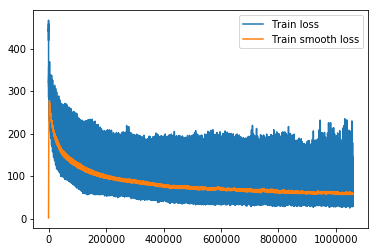

In [13]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()

plt.show()

Iter-10 loss: 104.0063
edite obA r h chrat t9.abodeca mw,'hna eth JyytvtEdmpm ta   l iehaeonthihla fl thsl  aiwkn  i t du1e 
Iter-20 loss: 91.4188
ee ifmacesaCtuoron mT "lctd I4danneg tonkiJ Nne Conedyarxrrr an .apolxrfegoil nun t8e fhp wacans aaaa
Iter-30 loss: 83.8331
e oatlxee Jepesnl rasl R8Hin eeopany ase ondteks a2,adedey 3oswoten cCtoran tira ane er ard phidoph S
Iter-40 loss: 79.3704
e8 Th af a9lha) al6ed Irxohons yunird was gapiWiTrgep atintt w oonmOas ar ase osmeglaner Cninds an Ao
Iter-50 loss: 76.2756
ed rathis ota% ras fhan aaol Winnetaer pered aonh licger, chiscunte sf an pist aintadlaldi-pal eskad 
Iter-60 loss: 74.0596
e fhons Ip Se-cer-m fity Sindicy wsmed opbires oJ the to 5r wi on ices ine bath lased al the sulint a
Iter-70 loss: 70.0485
ed fekmune, Ar, )heru om. aseeg riof en fiotisensushir innd 1upatered rist oso2seato y Daricll.exthe 
Iter-80 loss: 68.4188
ed pimh eaparly of if miansy prop Nedestih my anth then o-nh to sichithh worndas fintrtri1 Someand a 
Iter-90

Iter-670 loss: 37.2381
ered into reg poresease cegorion sting th lurleuf of en8. last an lontistion of Japan tited is tro, a
Iter-680 loss: 23.3519
e wosg profof Le courlity. Aplre 19ghite eastoring the sighan 15–20ed, Ty ced has pentens flgrsilita,
Iter-690 loss: 23.3475
ed hess and from the gan6"stereso hasban mented and peacunal ly and Wand Taly wige intlorof inteing A
Iter-700 loss: 29.7127
e world's as the Gmeto as who aast an lamand is and-bal rigest-la fourest Wonofs. Kolal, in Asis, thi
Iter-710 loss: 31.7488
e tosed il lard Japan so Oandexenmek7keopop Chin, fn 920s an any Ca wa and ixman I aigity lealled feu
Iter-720 loss: 23.2216
er aunlitary The For, rogeto in a nighily pare itoly linto se as fhimeChin's hinn pexthated naty of J
Iter-730 loss: 19.9716
e colaistu 9asd lakekud aed the Gighedd Japan th ne Asta Eas tre katy Suswing is fored and centh call
Iter-740 loss: 20.6436
e wotur temcorion is and Rision. Wa and wition is figh as Gs, wats the couthitewiplhe: lakestets telc


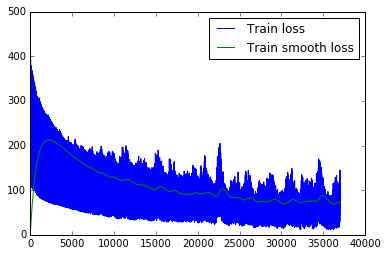

In [10]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 1000 # epochs
# alpha = 1e-3 # learning_rate
# p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# print_after = 10 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = RNN(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           p_dropout=p_dropout)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()

# plt.show()